#### Path retrieval and Dataframe creation

In [1]:
!pip freeze

absl-py==2.0.0
altair==4.0.0
anndata==0.10.8
ansi2html==1.9.1
anyio==4.2.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.7.1
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.14.0
beautifulsoup4==4.12.2
biopython==1.82
bleach==6.1.0
blinker==1.8.2
branca==0.7.2
cachetools==5.3.2
cattrs==23.2.3
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chembl-webresource-client==0.10.9
click==8.1.7
colorama==0.4.6
comm==0.2.0
contourpy==1.2.0
cycler==0.12.1
dash==2.17.0
dash-core-components==2.0.0
dash-html-components==2.0.0
dash-table==5.0.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
DendroPy==4.6.1
Deprecated==1.2.14
easydict==1.13
entrypoints==0.4
ete==1.0.0
ete3==3.1.3
exceptiongroup==1.2.0
executing==2.0.1
fanstatic==1.4
fastjsonschema==2.19.0
Flask==3.0.3
flatbuffers==24.3.25
folium==0.16.0
fonttools==4.47.0
fqdn==1.5.1
gast==0.4.0
get-annotations==0.1.2
gitdb==4.0.11
GitPython==3.1.43
google-auth==

In [20]:
import pandas as pd
import numpy as np
import os

In [21]:
parent_dir_path = os.getcwd()

In [22]:
os.listdir(parent_dir_path)

['.ipynb_checkpoints',
 '1model.h5',
 '1Untitled.ipynb',
 'app.py',
 'Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

In [23]:
def path_retrieval(parent_dir_path):
    data = []
    labels = []
    for item in os.listdir(parent_dir_path)[3:]:
        item_path = os.path.join(parent_dir_path, item)
        
        if os.path.isdir(item_path):
            for img in os.listdir(item_path):
                img_path = os.path.join(item_path, img)
                
                symlink_path = os.path.join(parent_dir_path, img)  # Keeping img_path for creating the symlink
    
                # Checking if the symbolic link already exists
                if os.path.exists(symlink_path):
                    os.remove(symlink_path)  # Remove the existing link
                
                os.symlink(img_path, symlink_path)
    
                # Appendding the data and label to the lists
                data.append(symlink_path)
                labels.append(item)

    df = pd.DataFrame({'path': data, 'breed': labels})
    return df    

In [24]:
df = path_retrieval(parent_dir_path)

#### Breed data prep

In [25]:
df['breed'].value_counts()

breed
Beagle                100
Boxer                 100
Bulldog               100
Poodle                100
Yorkshire_Terrier     100
Dachshund              96
German_Shepherd        96
Labrador_Retriever     95
Golden_Retriever       91
Rottweiler             89
Name: count, dtype: int64

In [26]:
df['breed'].unique()

array(['Beagle', 'Boxer', 'Bulldog', 'Dachshund', 'German_Shepherd',
       'Golden_Retriever', 'Labrador_Retriever', 'Poodle', 'Rottweiler',
       'Yorkshire_Terrier'], dtype=object)

In [27]:
df['breed'] = df['breed'].astype('category').cat.codes

In [28]:
# Each number corresponds to the class name at the same index
df['breed'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [29]:
df.head()

,path,breed
0,C:\Users\tobij\Desktop\Ipynb Tasks\Dog Breeds ...,0
1,C:\Users\tobij\Desktop\Ipynb Tasks\Dog Breeds ...,0
2,C:\Users\tobij\Desktop\Ipynb Tasks\Dog Breeds ...,0
3,C:\Users\tobij\Desktop\Ipynb Tasks\Dog Breeds ...,0
4,C:\Users\tobij\Desktop\Ipynb Tasks\Dog Breeds ...,0


In [30]:
# Path data conversion to array

In [31]:
import cv2

In [32]:
def img_prep(img_path, new_size):
    image = cv2.imread(img_path)
    image = cv2.resize(image, new_size) # Resizing the images
    image = image / 255.0 # Normalising the values
    return image

In [33]:
df.path = df.path.apply(lambda x: img_prep(x, (224, 224)))

In [34]:
df.head()

,path,breed
0,"[[[0.0, 0.00392156862745098, 0.0], [0.0, 0.003...",0
1,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
2,"[[[0.788235294117647, 0.6980392156862745, 0.72...",0
3,"[[[0.8666666666666667, 0.8431372549019608, 0.8...",0
4,"[[[0.5803921568627451, 0.6039215686274509, 0.6...",0


In [35]:
df.path.shape

(967,)

In [36]:
df.path.loc[0].shape

(224, 224, 3)

In [37]:
resized_x = np.array(df.path.tolist())

In [38]:
x = np.zeros((967, 224, 224, 3))

In [39]:
x = resized_x # Replacing the zeros in the x skeleton array with the values in the resized_x array

In [40]:
x.shape

(967, 224, 224, 3)

In [41]:
y = df.breed

#### Developing the CNN model

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.utils import to_categorical

In [45]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

In [46]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [47]:
y_train_c = to_categorical(y_train, num_classes=10)

In [48]:
model.fit(x_train, y_train_c, epochs=100, batch_size=10, verbose=0)

In [49]:
y_pred = model.predict(x_test).argmax(axis=1)

7/7 [==============================] - 1s 98ms/step


In [50]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [51]:
accuracy_score(y_test, y_pred)

0.9948453608247423

In [52]:
precision_score(y_test, y_pred, average='weighted')

0.9950908198330878

In [53]:
f1_score(y_test, y_pred, average='weighted')

0.9948301216845346

#### Evaluating the model

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

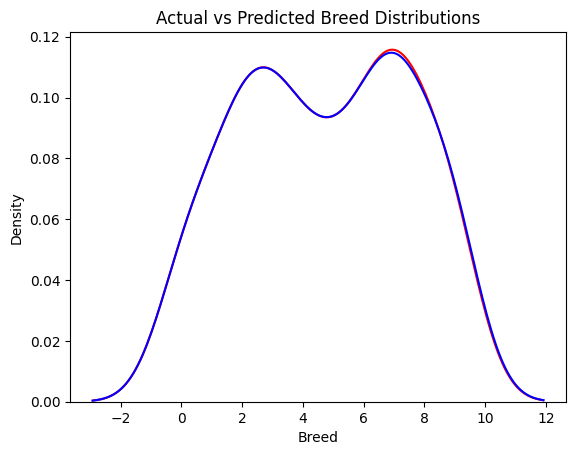

In [55]:
ax1 = sns.kdeplot(y_test, color="r", label="Actual Value")
sns.kdeplot(y_pred, color="b", label="Predicted Values" , ax=ax1)
plt.title('Actual vs Predicted Breed Distributions')
plt.xlabel('Breed');

In [56]:
results = pd.DataFrame(dict(actual=y_test, predicted=y_pred))

In [57]:
pd.crosstab(index=results.actual, columns=results.predicted)

predicted,0,1,2,3,4,5,6,7,8,9
actual,,,,,,,,,,
0,15,0,0,0,0,0,0,0,0,0
1,0,13,0,0,0,0,0,0,0,0
2,0,0,24,0,0,0,0,0,0,0
3,0,0,0,23,0,0,0,0,0,0
4,0,0,0,0,18,0,0,0,0,0
5,0,0,0,0,0,16,0,0,0,0
6,0,0,0,0,0,0,19,0,0,0
7,0,0,0,0,0,0,0,29,0,0
8,0,0,0,0,0,0,0,0,16,1


#### Building the app

In [60]:
model.save('model.h5')

The code below is to be run in the terminal to open streamlit
- cd C:\\Users\\tobij\\Desktop\\Ipynb Tasks\\Dog Breeds Dataset
- streamlit run app.py